In [1]:
import tensorflow as tf
import numpy as np
import os

2023-02-12 02:01:40.478847: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
shakespeare_text = None
with open('input.txt') as f:
    shakespeare_text = f.read()

In [3]:
vocab = sorted(set(shakespeare_text))
print ('The number of unique characters in the corpus is', len(vocab))
print('A slice of the unique characters set:\n', vocab[:10])

The number of unique characters in the corpus is 65
A slice of the unique characters set:
 ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3']


In [4]:
char2idx = {u:i for i, u in enumerate(vocab)}
# Make a copy of the unique set elements in NumPy array format for later use in the decoding the predictions
idx2char = np.array(vocab)
# Vectorize the text with a for loop
text_as_int = np.array([char2idx[c] for c in shakespeare_text])

In [5]:

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) 
# for i in char_dataset.take(5): 
#   print(i.numpy())
seq_length = 100 # The max. length for single input
# examples_per_epoch = len(text)//(seq_length+1) # double-slash for “floor” division
sequences = char_dataset.batch(seq_length+1, drop_remainder=True) 
# for item in sequences.take(5): 
#   print(repr(''.join(idx2char[item.numpy()])))

2023-02-12 02:01:44.825259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:

def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

In [7]:
BUFFER_SIZE = 10000 # TF shuffles the data only within buffers

BATCH_SIZE = 64 # Batch size

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

print(dataset)

<BatchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>


In [8]:
# Length of the vocabulary in chars
vocab_size = len(vocab)
# The embedding dimension
embedding_dim = 256
# Number of RNN units
rnn_units = 1024

In [9]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [10]:
model = build_model(
    vocab_size = len(vocab), # no. of unique characters
    embedding_dim=embedding_dim, # 256
    rnn_units=rnn_units, # 1024
    batch_size=BATCH_SIZE)  # 64 for the traning

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           16640     
                                                                 
 gru (GRU)                   (64, None, 1024)          3938304   
                                                                 
 dense (Dense)               (64, None, 65)            66625     
                                                                 
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [11]:

def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# example_batch_loss  = loss(target_example_batch, example_batch_predictions)
# print("Prediction shape: ", example_batch_predictions.shape, " (batch_size, sequence_length, vocab_size)")
# print("scalar_loss:      ", example_batch_loss.numpy().mean())

model.compile(optimizer='adam', loss=loss)

In [12]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [32]:
it = dataset.as_numpy_iterator()
d1, d2 = it.next()
print(d1)
print(d2)

[[ 0 27  5 ... 46 47 51]
 [ 1 15 59 ... 49  1 41]
 [39  1 41 ... 10  0 21]
 ...
 [52  1 51 ... 59 42  1]
 [ 1 39 52 ...  1 63 43]
 [42  1 63 ... 52 42 59]]
[[27  5  1 ... 47 51 10]
 [15 59 54 ...  1 41 46]
 [ 1 41 59 ...  0 21  1]
 ...
 [ 1 51 59 ... 42  1 58]
 [39 52 42 ... 63 43 39]
 [ 1 63 53 ... 42 59 56]]


In [ ]:

EPOCHS = 30
history = model.fit(dataset, 
                    epochs=EPOCHS, 
                    callbacks=[checkpoint_callback])

In [ ]:
def generate_text(model, num_generate, temperature, start_string):
  input_eval = [char2idx[s] for s in start_string] # string to numbers (vectorizing)
  input_eval = tf.expand_dims(input_eval, 0) # dimension expansion
  text_generated = [] # Empty string to store our results
  model.reset_states() # Clears the hidden states in the RNN

  for i in range(num_generate): #Run a loop for number of characters to generate
    predictions = model(input_eval) # prediction for single character
    predictions = tf.squeeze(predictions, 0) # remove the batch dimension

    # using a categorical distribution to predict the character returned by the model
    # higher temperature increases the probability of selecting a less likely character
    # lower --> more predictable
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    # The predicted character as the next input to the model
    # along with the previous hidden state
    # So the model makes the next prediction based on the previous character
    input_eval = tf.expand_dims([predicted_id], 0) 
    # Also devectorize the number and add to the generated text
    text_generated.append(idx2char[predicted_id]) 

  return (start_string + ''.join(text_generated))

In [ ]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            16640     
                                                                 
 gru_3 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_2 (Dense)             (1, None, 65)             66625     
                                                                 
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [ ]:
generated_text = generate_text(
                    model, 
                    num_generate=500, 
                    temperature=1, 
                    start_string=u"ROMEO")
print(generated_text)

ROMEO:
Come, sir, and I dare not say he: 'fore mestrum lies you into my house;
For both offen, ere they give;
And, for I am a manner of mercy. And his wonder;
Nor what am too much first and what time had made
That thou art.

AUFIDIUS:
You have done enough, nor worse: is't my speech and
Willought to my foe till thou do: abother,
If he hath lost advanced. O, whilst I dur
boy, thou art a tall fellow, and his
school'd my wife!

ANTONIO:
His noble country's reasons of the worst
Of Sochaid to be unclar, ev


(0.0, 1.0)

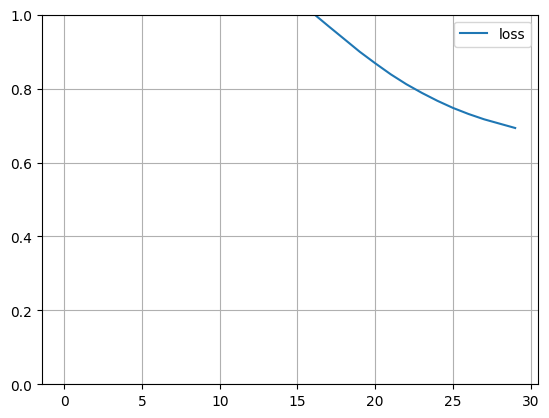

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot() 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts([shakespeare_text])

In [ ]:
tokenizer.texts_to_sequences(["First"]), tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]]), tokenizer.texts_to_sequences([" "])

([[20, 6, 9, 8, 3]], ['f i r s t'], [[1]])

In [ ]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

max_id, dataset_size

(39, 1)

In [ ]:
# encode the full text so each character is represented by its ID 
# (we subtract 1 to get IDs from 0 to 38, rather than from 1 to 39)

[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [ ]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [ ]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead 
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset 

<FlatMapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

In [ ]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [30]:
dataset[:1, :1]

TypeError: 'BatchDataset' object is not subscriptable

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id], dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))])
    
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [ ]:
history = model.fit(dataset, epochs=20)

Epoch 1/20


ValueError: in user code:

    File "/Users/piyushr/workspace/personal/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/piyushr/workspace/personal/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/piyushr/workspace/personal/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/piyushr/workspace/personal/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/Users/piyushr/workspace/personal/venv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/piyushr/workspace/personal/venv/lib/python3.9/site-packages/keras/engine/input_spec.py", line 232, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "gru" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, None)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None, None), dtype=int64)
      • training=True
      • mask=None
